In [79]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [80]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [81]:
len(words)

32033

In [82]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [83]:
# build the dataset
block_size = 3
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w+'.':
      X.append(context)
      ix = stoi[ch]
      Y.append(ix)
      context = context[1:]+[ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [100]:
# MLP revisited
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), 						generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, 											generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),				generator=g) * 0.01
b2 = torch.randn(vocab_size, 										generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
	p.requires_grad = True

11897


In [105]:
max_steps = 20000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if (i%1000==0):
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())
  #break

      0/  20000: 3.244580
   1000/  20000: 2.382418
   2000/  20000: 2.237192
   3000/  20000: 2.443782
   4000/  20000: 1.936350
   5000/  20000: 2.288827
   6000/  20000: 2.352497
   7000/  20000: 2.328722
   8000/  20000: 2.345773
   9000/  20000: 2.499775
  10000/  20000: 1.904645
  11000/  20000: 2.232810
  12000/  20000: 2.109411
  13000/  20000: 2.232121
  14000/  20000: 2.082495
  15000/  20000: 2.206302
  16000/  20000: 2.627117
  17000/  20000: 2.579437
  18000/  20000: 1.850443
  19000/  20000: 2.574862


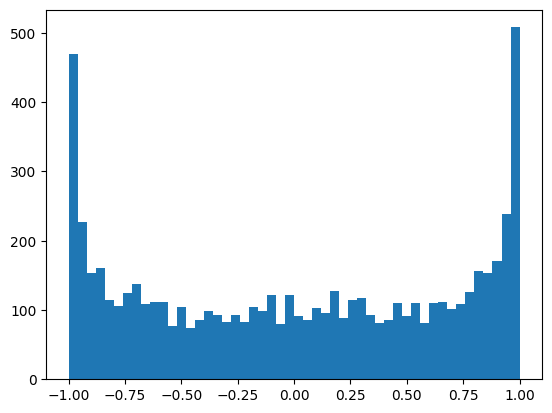

In [106]:
plt.hist(h.view(-1).tolist(),50);

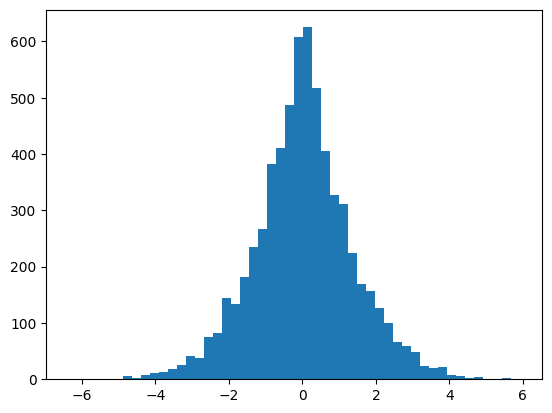

In [107]:
plt.hist(hpreact.view(-1).tolist(),50);

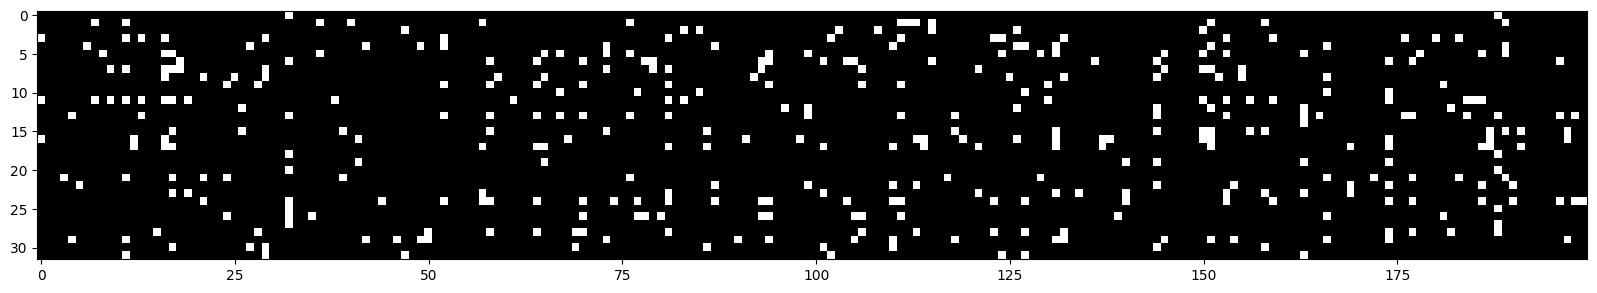

In [108]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

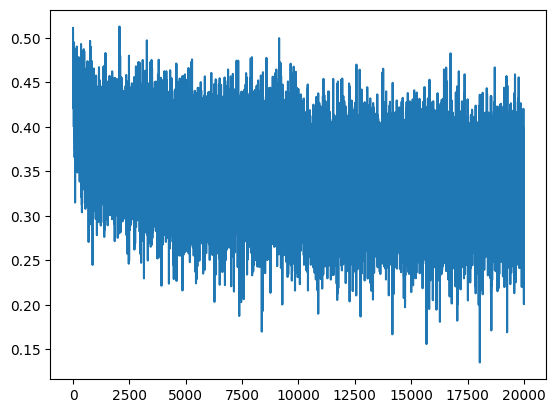

In [109]:
plt.plot(lossi)

In [110]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte,Yte )
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1619248390197754
val 2.179323434829712


In [111]:
h.shape

torch.Size([32, 200])

In [114]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647+12)
for _ in range(20):
	out = []
	context = [0]*block_size
	while True:
		emb = C[torch.tensor([context])]
		h = torch.tanh(emb.view(1,-1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1,generator=g).item()
		context = context[1:]+[ix]
		out.append(ix)
		if ix == 0:
			break
	print(''.join(itos[i] for i in out))


kahdi.
zak.
kadridhaki.
jaylia.
vand.
nashellies.
mali.
kelenna.
theruevelia.
mer.
alynnveyaan.
jand.
azalissonathed.
den.
masy.
har.
aadria.
tayan.
layja.
reeng.
